In [22]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [23]:
import numpy as np

from astropy import units as u

from scipy.interpolate import CubicSpline
from scipy.integrate import cumulative_trapezoid, quad
from scipy.optimize import minimize

from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.concentration_models import ConcentrationDiemerJoyce

util = LensCosmo()
concentration_model = ConcentrationDiemerJoyce(util.cosmo.astropy, scatter=False)

import isolated_halo

In [24]:
import importlib
importlib.reload(isolated_halo)

<module 'isolated_halo' from '/Users/vinhtran/Data/Research/Mark/Eddington Sampling/eddington_ICs_sampling/isolated_halo.py'>

In [25]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib as mpl

# define matplotlib style
plt.style.use('classic')
mpl.rc('xtick', labelsize=23); mpl.rc('ytick', labelsize=23)
mpl.rc('xtick.major', size=15 , width=2)
mpl.rc('xtick.minor', size=8, width=2, visible=True)
mpl.rc('ytick.major', size=15 , width=2)
mpl.rc('ytick.minor', size=8, width=2, visible=True)
mpl.rc('lines',linewidth=3, markersize=20)
mpl.rc('axes', linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc('legend', fontsize=25, loc='best', frameon=False, numpoints=1)

mpl.rc('font', family='STIXGeneral')
mpl.rc('mathtext', fontset='stix')

In [26]:
m200 = 1e10
c = concentration_model.nfw_concentration(m200, 0)
rhos, rs, r200 = util.NFW_params_physical(m200, c, 0)

In [28]:
class NFWICs(isolated_halo.BaseICs):
    def __init__(self, 
                 rhos, rs, r200,
                 seed=100):
        self.rhos = rhos
        self.rs = rs
        self.r200 = r200
        super().__init__(r_bin_min=1e-5*rs, r_bin_max=1e3*r200, N_bins=10000,
                         r_sample_min=1e-4*rs, r_sample_max=3*r200, N_part=int(2e6),
                         seed=seed)

    def _nfw_density(self, r):
        return self.rhos / (r/self.rs) / (1 + r/self.rs)**2
    def _decay_density(self, r):
        c = self.r200/self.rs
        eps = 1 - (1 + 3*c) / (1 + c)
        return self.rhos / (c * (1 + c)**2) * (r/self.r200)**eps * np.exp(-(r/self.r200-1))

    def _get_rho_bins(self, r_bins):
        return np.where(
            r_bins < self.r200,
            self._nfw_density(r_bins), 
            self._decay_density(r_bins)
        )

In [29]:
nfw_ics = NFWICs(rhos, rs, r200)

nfw_reconstructed_rho_bins = nfw_ics.reconstruct_density(
    nfw_ics.phi_bins, nfw_ics.eta_bins, nfw_ics.f_eta_bins
)

part_mass,\
part_x, part_y, part_z,\
part_vx, part_vy, part_vz = nfw_ics.generate_ICs(output='../Test Halos/1e10/ICs_m-1e10_N-2e6.hdf5',)

part_r = np.sqrt(part_x**2 + part_y**2 + part_z**2)
part_vs = np.array([part_vx, part_vy, part_vz]).T

Proposal distributions:: 100%|██████████| 9999/9999 [00:19<00:00, 500.22it/s] 


  inter 10: 8979
  inter 20: 55
  inter 30: 5
  inter 40: 2
  inter 50: 1
  inter 60: 1


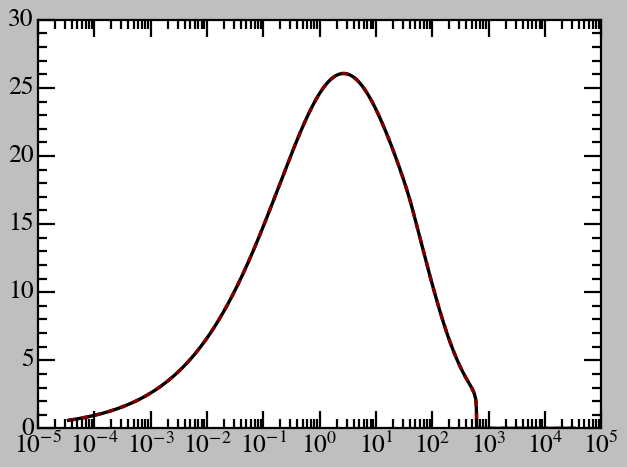

In [30]:
_delta_rho_sigma_r_sqr_integrand = nfw_ics.G * nfw_ics.mass_bins * nfw_ics.rho_bins / nfw_ics.r_bins**2
_delta_rho_sigma_r_sqr_bins = cumulative_trapezoid(
    _delta_rho_sigma_r_sqr_integrand, nfw_ics.r_bins, initial=0
)
_sigma_r_bins = np.sqrt(
    (_delta_rho_sigma_r_sqr_bins[-1] - _delta_rho_sigma_r_sqr_bins) / nfw_ics.rho_bins
)

plt.plot(nfw_ics.r_bins, nfw_ics.sigma_r_bins, label='NFW density', color='black')
plt.plot(nfw_ics.r_bins, _sigma_r_bins, label='NFW density', color='maroon', linestyle='--')

plt.xscale('log')
# plt.yscale('log')

# plt.ylim(1e-0, 1e13)

plt.tight_layout()
plt.show()

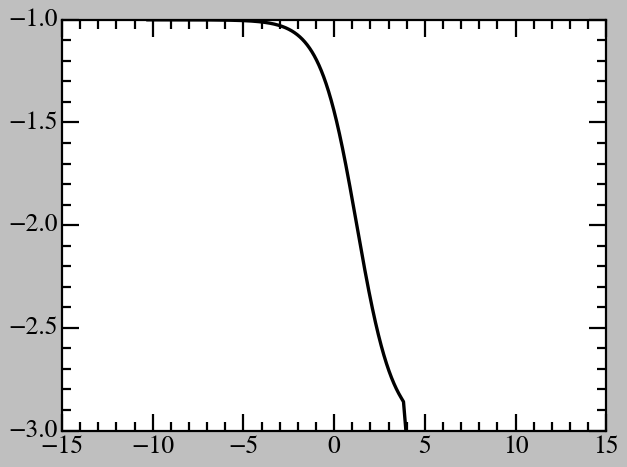

In [31]:
_lin_lin_dlogrho_dlogr_interp = nfw_ics._get_interp(
    (np.log(nfw_ics.r_bins[:-1]) + np.log(nfw_ics.r_bins[1:])) / 2,
    np.diff(np.log(nfw_ics.rho_bins)) / np.diff(np.log(nfw_ics.r_bins))
)

plt.plot(
    (np.log(nfw_ics.r_bins[:-1]) + np.log(nfw_ics.r_bins[1:])) / 2,
    np.diff(np.log(nfw_ics.rho_bins)) / np.diff(np.log(nfw_ics.r_bins)),
    label='NFW', color='black'
)

# plt.plot(nfw_ics.r_bins, _lin_lin_dlogrho_dlogr_interp(np.log(nfw_ics.r_bins)), label='NFW', color='black')

# plt.xscale('log')
# plt.yscale('log')

plt.ylim(-3,-1)

plt.tight_layout()
plt.show()

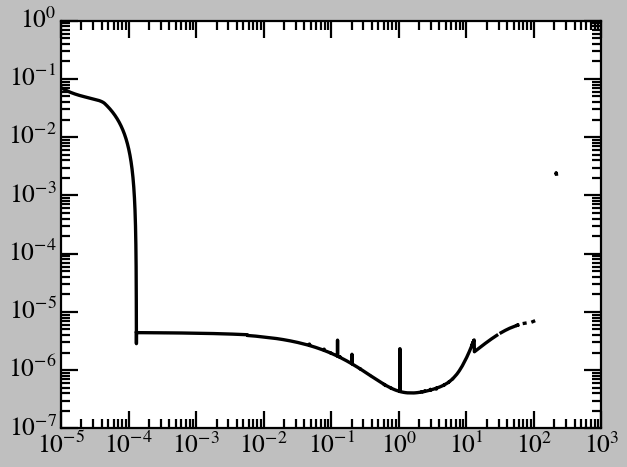

In [37]:
rho_mass = nfw_ics.rho_bins > 0
plt.plot(nfw_ics.r_bins[rho_mass] / nfw_ics.rs, np.abs(nfw_reconstructed_rho_bins[rho_mass]/nfw_ics.rho_bins[rho_mass] - 1), label='NFW', color='black')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-7,1)

plt.tight_layout()
plt.show()

In [33]:
class SimpleHaloInspection:
    def __init__(self,
                 part_mass,part_r,part_vs,
                 part_r_bins):
        self.m = part_mass
        self.r = part_r
        self.vs = part_vs

        self.r_bins = part_r_bins

    def _get_counts(self):
        counts, _ = np.histogram(self.r, bins=self.r_bins)
        bin_centers = (self.r_bins[1:] + self.r_bins[:-1]) / 2

        return counts, bin_centers

    def get_sampled_rho(self):
        counts, bin_centers = self._get_counts()
        bin_volumes = 4/3*np.pi * (self.r_bins[1:]**3 - self.r_bins[:-1]**3)

        rhos = counts * self.m / bin_volumes
        rhos_err = np.sqrt(counts) * self.m / bin_volumes

        mask = counts > 1

        return bin_centers[mask], rhos[mask], rhos_err[mask]
    
    def get_sampled_sigma(self):
        counts, bin_centers = self._get_counts()
        bin_indices = np.digitize(self.r, self.r_bins) - 1

        sigmas = np.array([
            np.std(self.vs[bin_indices == i]) for i in range(len(self.r_bins)-1)
        ])
        sigmas_err = sigmas / np.sqrt(2*3*counts)

        mask = counts > 1

        return bin_centers[mask], sigmas[mask], sigmas_err[mask]

In [34]:
halo_inspection = SimpleHaloInspection(
    part_mass*1e10/nfw_ics.rhos/nfw_ics.rs**3, part_r/nfw_ics.rs, part_vs/np.sqrt(nfw_ics.G*nfw_ics.rhos*nfw_ics.rs**2),
    np.logspace(-3, 2, 31)
)

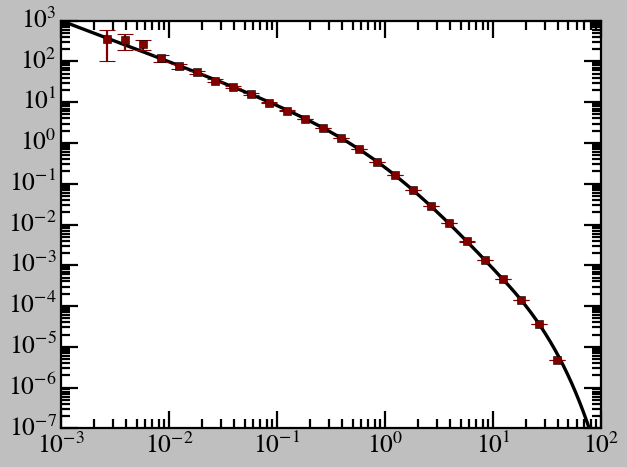

In [35]:
bin_centers, rho_bins, rho_bins_err = halo_inspection.get_sampled_rho()

plt.plot(nfw_ics.r_bins/nfw_ics.rs, nfw_ics.rho_bins/nfw_ics.rhos, label='NFW', color='black')
plt.errorbar(bin_centers, rho_bins, yerr=rho_bins_err, 
             fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1,
             label='Sampled', color='maroon')

plt.xscale('log')
plt.yscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(1e-7,1e3)

plt.tight_layout()
plt.show()

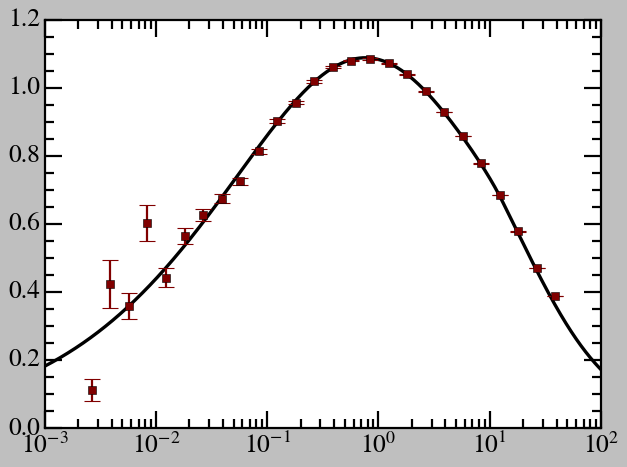

In [36]:
bin_centers, sigmas, sigmas_err = halo_inspection.get_sampled_sigma()

plt.plot(nfw_ics.r_bins/nfw_ics.rs, nfw_ics.sigma_r_bins/np.sqrt(nfw_ics.G*nfw_ics.rhos*nfw_ics.rs**2), 
         label='NFW', color='black')
plt.errorbar(bin_centers, sigmas, yerr=sigmas_err, 
             fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1,
             label='Sampled', color='maroon')

plt.xscale('log')
# plt.yscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(0,1.2)

plt.tight_layout()
plt.show()